In [55]:
import sys
import os
from my_functions_new import *
from my_plotting_functions import *

# Define whether to filter out values <0.1
remove_little_values = True

### Read in the resized land cover file, clip it and update some parameters 

In [2]:
landcover, out_meta = open_and_clip(model_directory + "LandCover_resized.tif")
out_meta.update({"nodata":np.nan, "dtype" :'float64' })
landcover[landcover == -2147483648] = np.nan
save_array_as_raster(landcover, model_directory +"LandCover_clipped.tif", out_meta)

### Check the shape

In [5]:
landcover.shape

(7801, 8501)

### Plot

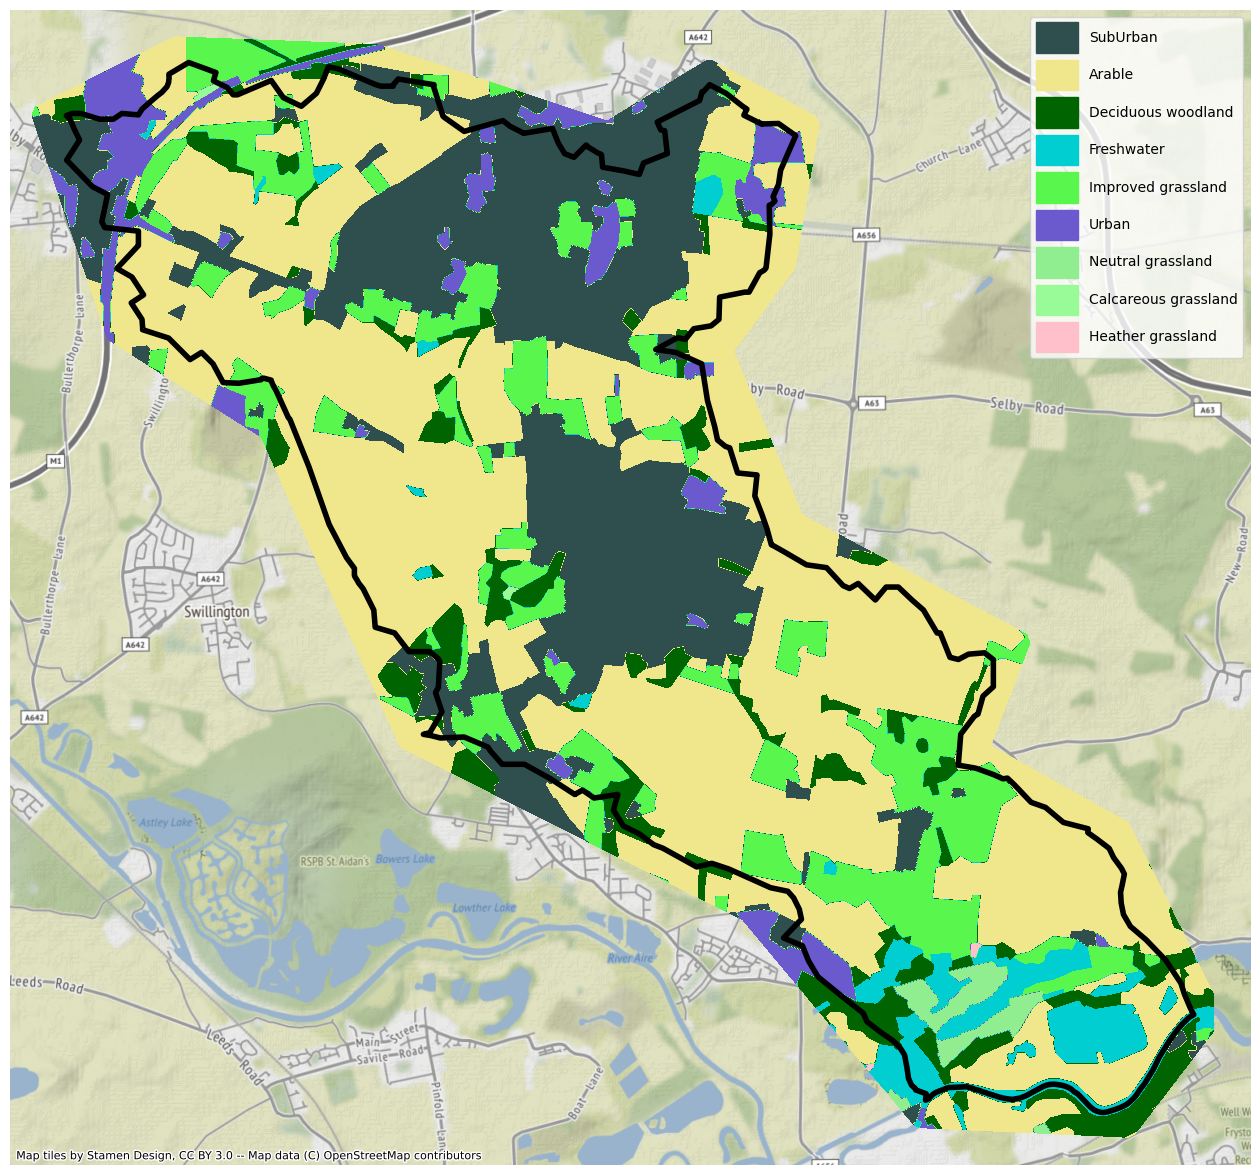

In [3]:
clipped = rasterio.open(model_directory +"LandCover_clipped.tif")
labels= ['SubUrban', 'Arable', 'Deciduous woodland', 'Freshwater', 'Improved grassland', 'Urban', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland']
colors = ['darkslategrey', 'khaki', 'darkgreen','darkturquoise','#59F74D', 'slateblue', 'lightgreen', 'palegreen', 'pink']
cmap = mpl.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(20, 15))
catchment_gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)
cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
rasterio.plot.show((clipped, 1), ax= ax, cmap=cmap)

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()

# Create patches for legend
patches_list = []
for i, color in  enumerate(colors):
    patch =  mpatches.Patch(color=color, label=labels[i])
    patches_list.append(patch)  

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()
plt.axis('off')
plt.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =10);

In [4]:
# Convert the 1 and 6 values to 10 (for urban) and the rest to 11 (for non-urban).  
landcover_mod =  np.where(landcover==1, 10, landcover)
landcover_mod =  np.where(landcover_mod==6, 10, landcover_mod)
# Convert the rest of the classes to 11
for i in [1,2,3,4,5,7,8,9]:
    landcover_mod =  np.where(landcover_mod==i, 11, landcover_mod)

### Find proportion of cells that are urban

In [33]:
# unique_vals = np.unique(landcover_mod, return_counts=True)
round((unique_vals[1][0] / (unique_vals[1][0] + unique_vals[1][1] + unique_vals[1][2])) * 100,2)

12.05

In [45]:
save_array_as_raster(landcover_mod, model_directory +"LandCover_clipped_reclassified.tif", out_meta)

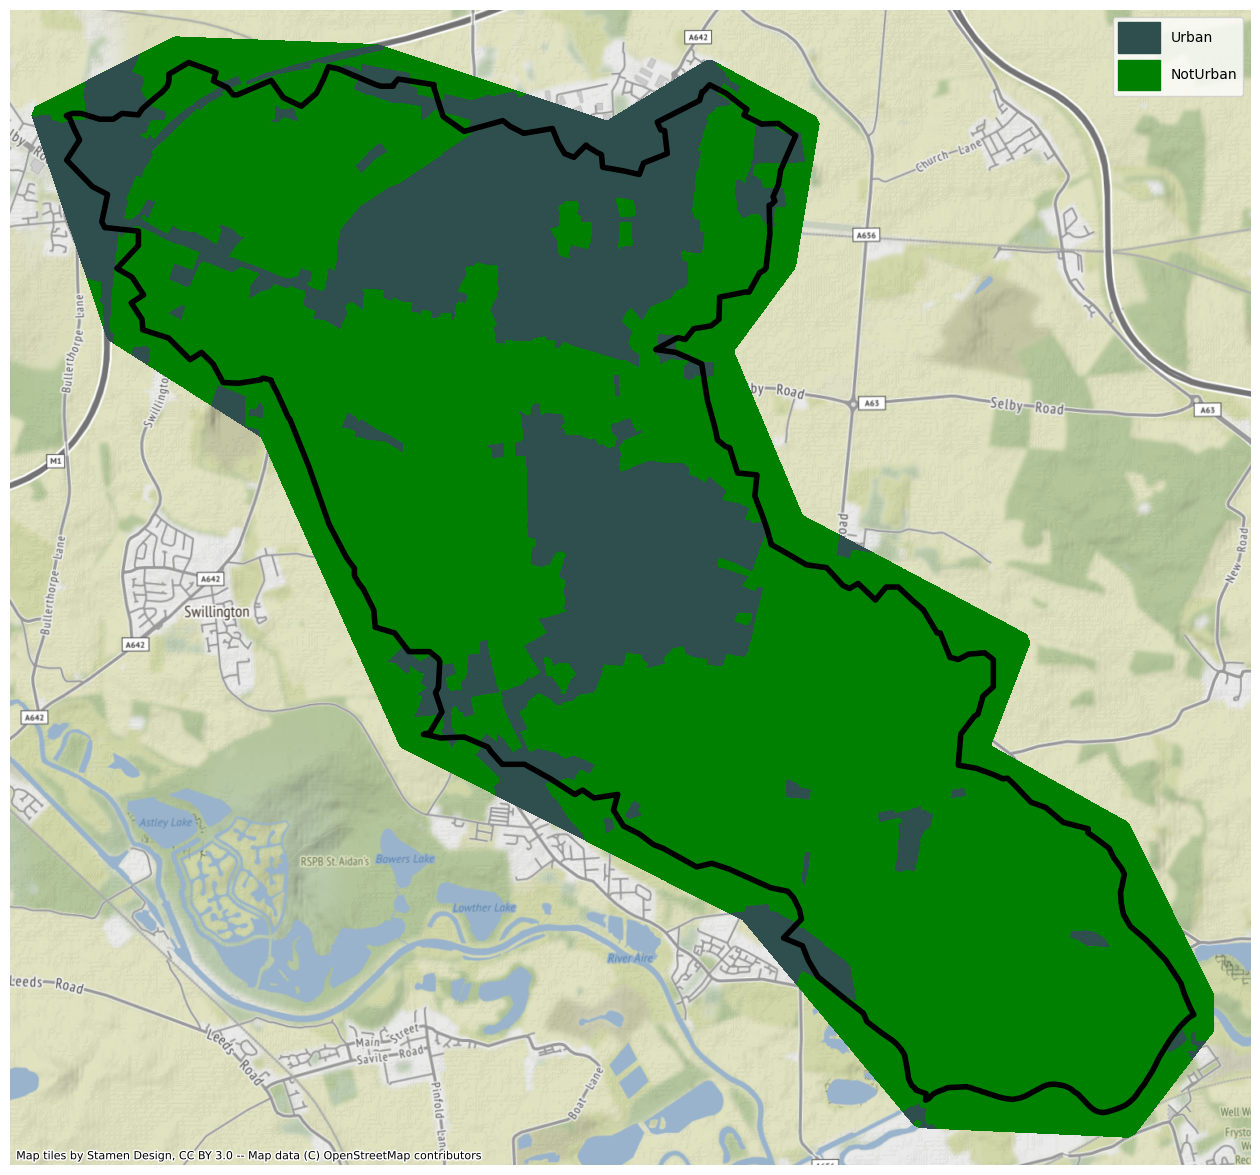

In [47]:
clipped = rasterio.open(model_directory +"LandCover_clipped_reclassified.tif")
labels= ['Urban', 'NotUrban']
colors = ['darkslategrey', 'green']
cmap = mpl.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(20, 15))
catchment_gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)
cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
rasterio.plot.show((clipped, 1), ax= ax, cmap=cmap)

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()

# Create patches for legend
patches_list = []
for i, color in  enumerate(colors):
    patch =  mpatches.Patch(color=color, label=labels[i])
    patches_list.append(patch)  

# Close file (otherwise can't delete it, as ref to it is open)
clipped.close()
plt.axis('off')
plt.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =10);

In [58]:
# Set up figure
f = folium.Figure(width=800, height=700)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=13).add_to(f)
folium.TileLayer(
    tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",
    name="No Base Map",
    show=True
).add_to(mapa)

# Add to map
catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                                          fillColor='#00000000', color='Black': {
        "fillColor": '#00000000',"color": 'Black',}))
name = 'land_classified'

xarray_dataarray = prep_for_folium_plotting(model_directory +"LandCover_clipped_reclassified.tif")
# Get coordinates needed in plotting
clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
# Apply colormap
data  = ma.masked_invalid(xarray_dataarray.values)
colored_data = colorize(data.data, cmap=cmap)
# Add to map
feature_group1 = FeatureGroup(name=name)
feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data,
                          [[mlat, mlon], [xlat, xlon]],
                          opacity=0.8,interactive=True, popup=name))
mapa.add_child(feature_group1)


# Add layer control button
mapa.add_child(catchment_boundary_feature_group)
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)